In [4]:
import functools
import os
import pandas as pd
import e3x
import flax.linen as nn
import jax
import numpy as np
import optax
# Disable future warnings.
import warnings
import pickle

warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
plt.set_cmap('bwr')

import jax.numpy as jnp
from jax import jit, grad
from jax import vmap
batch_size = 16
NATOMS = 60

<Figure size 640x480 with 0 Axes>

In [5]:
def evaluate_dc(batch, dipo, mono, batch_size, plot=False, rcut=10000):
    esp_dc_pred = esp_mono_loss_pots(dipo, mono, batch['esp'], 
                             batch['vdw_surface'], batch['mono'], 
                             batch_size)

    mono_pred =  esp_loss_pots(batch['positions'], batch['mono'], batch['esp'],
                        batch['vdw_surface'], batch['mono'], batch_size)

    non_zero = np.nonzero(batch["mono"])

    if plot:
    
        plt.scatter(batch["mono"][non_zero], 
                    mono.sum(axis=-1).squeeze()[non_zero])
        loss = esp_loss_eval(batch["mono"][non_zero], mono.sum(axis=-1).squeeze()[non_zero], None)
        plt.title(loss)
        plt.plot([-1,1],[-1,1],c="k",alpha=0.5)
        plt.xlim(-1,1)
        plt.ylim(-1,1)
        ax=plt.gca()
        ax.set_aspect("equal")
        plt.show()
        
        for id in range(batch_size):
            plt.scatter(esp_dc_pred[id][:batch['ngrid'][id]],
                        batch['esp'][id][:batch['ngrid'][id]], alpha=0.1)
     
        ax = plt.gca()
        plt.xlim(-0.1, 0.1)
        plt.ylim(-0.1, 0.1)
        plt.plot([-1,1],[-1,1],c="k",alpha=0.5)
        ax.set_aspect("equal")
        plt.show()

    esp_errors = []
    
    for mbID in range(batch_size):
        xyzs = batch['positions'].reshape(batch_size,60, 3)
        vdws = batch['vdw_surface'][mbID][:batch['ngrid'][mbID]]
        diff = xyzs[mbID][:, None, :] - vdws[None, :, :]
        r = np.linalg.norm(diff, axis=-1) 
        min_d = np.min(r, axis=-2)
        wheremind = np.where( min_d < rcut, min_d, 0)
        idx_cut = np.nonzero(wheremind)[0]
        loss1 = esp_loss_eval(esp_dc_pred[mbID][:batch['ngrid'][mbID]][idx_cut], 
                      batch['esp'][mbID][:batch['ngrid'][mbID]][idx_cut],
                      batch['ngrid'][mbID])
        loss2 = esp_loss_eval(mono_pred[mbID][:batch['ngrid'][mbID]][idx_cut], 
                      batch['esp'][mbID][:batch['ngrid'][mbID]][idx_cut],
                      batch['ngrid'][mbID])
        esp_errors.append([loss1, loss2])

        if plot:
            
            fig = plt.figure(figsize=(12,6))
            
            ax1 = fig.add_subplot(151, projection='3d')
            s = ax1.scatter(*batch['vdw_surface'][mbID][:batch['ngrid'][mbID]][idx_cut].T, 
                           c=clip_colors(batch['esp'][mbID][:batch['ngrid'][mbID]][idx_cut]), 
                           vmin=-0.015, vmax=0.015)
            ax1.set_title(f"GT {mbID}")
            
    
            ax2 = fig.add_subplot(152, projection='3d')
            s = ax2.scatter(*batch['vdw_surface'][mbID][:batch['ngrid'][mbID]][idx_cut].T, 
                           c=clip_colors(esp_dc_pred[mbID][:batch['ngrid'][mbID]][idx_cut]), 
                           vmin=-0.015, vmax=0.015)
            ax2.set_title(loss1)
            
            ax4 = fig.add_subplot(153, projection='3d')
            s = ax4.scatter(*batch['vdw_surface'][mbID][:batch['ngrid'][mbID]][idx_cut].T, 
                           c=clip_colors(esp_dc_pred[mbID][:batch['ngrid'][mbID]][idx_cut]
                                        - batch['esp'][mbID][:batch['ngrid'][mbID]][idx_cut]
                                        ), 
                           vmin=-0.015, vmax=0.015)
    
    
            ax3 = fig.add_subplot(154, projection='3d')
            s = ax3.scatter(*batch['vdw_surface'][mbID][:batch['ngrid'][mbID]][idx_cut].T, 
                           c=clip_colors(mono_pred[mbID][:batch['ngrid'][mbID]][idx_cut]), 
                           vmin=-0.015, vmax=0.015)
            ax3.set_title(loss2)
    
            ax5 = fig.add_subplot(155, projection='3d')
            s = ax5.scatter(*batch['vdw_surface'][mbID][:batch['ngrid'][mbID]][idx_cut].T, 
                           c=clip_colors(mono_pred[mbID][:batch['ngrid'][mbID]][idx_cut]
                                        - batch['esp'][mbID][:batch['ngrid'][mbID]][idx_cut]
                                        ), 
                           vmin=-0.015, vmax=0.015)
    
    
    
            for _ in [ax1,ax2,ax3]:
                _.set_xlim(-10,10)
                _.set_ylim(-10,10)
                _.set_zlim(-10,10)
            plt.show()
        
    return esp_errors


In [6]:
from esp_net import prepare_datasets,prepare_batches

def nan_safe_coulomb_potential(q, r):
    potential = jnp.where(jnp.isnan(r) | (r == 0.0), 0.0, q / (r * 1.88973))
    return potential


def calc_esp(charge_positions, charge_values, grid_positions, mono):
    chg_mask = jnp.where(mono != 0, 1.0, 0.0)
    # Expand the grid positions and charge positions to compute all pairwise differences
    diff = grid_positions[:, None, :] - charge_positions[None, :, :]
    # Compute the Euclidean distance between each grid point and each charge
    r = jnp.linalg.norm(diff, axis=-1)
    sum_chg = jnp.sum(chg_mask * charge_values)
    # jax.debug.print("x = {x}", x=sum_chg)
    avg_chg = jnp.sum(chg_mask * charge_values) / jnp.sum(chg_mask)
    new_charge_values = charge_values - avg_chg
    # sum_chg_new = jnp.sum(chg_mask * new_charge_values)
    # jax.debug.print("x2 = {x}", x=sum_chg_new)
    C = nan_safe_coulomb_potential((chg_mask * new_charge_values)[None, :], r)
    V = jnp.sum(C, axis=-1)
    return V

def esp_loss_eval(pred, target, ngrid):
    target = target.flatten()
    esp_non_zero = np.nonzero(target)
    l2_loss = optax.l2_loss(pred[esp_non_zero], target[esp_non_zero])
    esp_loss = np.mean(l2_loss)
    esp_loss = esp_loss * 1  
    return esp_loss
    
batched_electrostatic_potential = vmap(calc_esp, in_axes=(0, 0, 0, 0), out_axes=0)


def clip_colors(c):
    return np.clip(c, -0.015, 0.015)


@functools.partial(jax.jit, static_argnames=('batch_size', 'esp_w'))
def esp_mono_loss(dipo_prediction, mono_prediction, esp_target,
                  vdw_surface, mono, batch_size, esp_w):
    """
    """
    nonzero = jnp.nonzero(mono, size=batch_size * 60)
    l2_loss_mono = optax.l2_loss(mono_prediction.sum(axis=-1), mono)
    mono_loss = jnp.mean(l2_loss_mono[nonzero])

    d = dipo_prediction.reshape(batch_size, NATOMS, 3, n_dcm)
    d = jnp.moveaxis(d, -1, -2)
    d = d.reshape(batch_size, NATOMS * n_dcm, 3)
    mono = jnp.repeat(mono.reshape(batch_size, NATOMS), n_dcm, axis=-1)
    m = mono_prediction.reshape(batch_size, NATOMS * n_dcm)

    batched_pred = batched_electrostatic_potential(d, m, vdw_surface, mono).flatten()
    esp_target = esp_target.flatten()
    esp_non_zero = jnp.nonzero(esp_target, size=batch_size * 3143)

    l2_loss = optax.l2_loss(batched_pred, esp_target)
    esp_loss = jnp.mean(l2_loss[esp_non_zero])
    esp_loss = esp_loss * esp_w
    return esp_loss + mono_loss


def esp_mono_loss_pots(dipo_prediction, mono_prediction, esp_target,
                       vdw_surface, mono, batch_size):
    """
    """
    d = dipo_prediction.reshape(batch_size, NATOMS, 3, n_dcm)
    d = jnp.moveaxis(d, -1, -2)
    d = d.reshape(batch_size, NATOMS * n_dcm, 3)
    mono = jnp.repeat(mono.reshape(batch_size, NATOMS), n_dcm, axis=-1)
    m = mono_prediction.reshape(batch_size, NATOMS * n_dcm)

    batched_pred = batched_electrostatic_potential(d, m, vdw_surface, mono)

    return batched_pred


def esp_loss_pots(dipo_prediction, mono_prediction,
                  esp_target, vdw_surface, mono, batch_size):
    d = dipo_prediction.reshape(batch_size, NATOMS, 3)
    mono = mono.reshape(batch_size, NATOMS)
    m = mono_prediction.reshape(batch_size, NATOMS)
    batched_pred = batched_electrostatic_potential(d, m, vdw_surface, mono)

    return batched_pred


def mean_absolute_error(prediction, target, batch_size):
    nonzero = jnp.nonzero(target, size=batch_size * 60)
    return jnp.mean(jnp.abs(prediction[nonzero] - target[nonzero]))

In [52]:
NATOMS = 60
class MessagePassingModel(nn.Module):
    features: int = 32
    max_degree: int = 2
    num_iterations: int = 3
    num_basis_functions: int = 8
    cutoff: float = 5.0
    max_atomic_number: int = 17
    n_dcm: int = 4

    def mono(self, atomic_numbers, positions, dst_idx, src_idx, batch_segments,
             batch_size):
        # 1. Calculate displacement vectors.
        positions_dst = e3x.ops.gather_dst(positions, dst_idx=dst_idx)
        positions_src = e3x.ops.gather_src(positions, src_idx=src_idx)
        displacements = positions_src - positions_dst  # Shape (num_pairs, 3).

        # 2. Expand displacement vectors in basis functions.
        basis = e3x.nn.basis(
            # Shape (num_pairs, 1, (max_degree+1)**2, num_basis_functions).
            displacements,
            num=self.num_basis_functions,
            max_degree=self.max_degree,
            radial_fn=e3x.nn.reciprocal_bernstein,
            cutoff_fn=functools.partial(e3x.nn.smooth_cutoff, cutoff=self.cutoff)
        )

        x = e3x.nn.Embed(num_embeddings=self.max_atomic_number + 1,
                         features=self.features)(atomic_numbers)

        # 4. Perform iterations (message-passing + atom-wise refinement).
        for i in range(self.num_iterations):
            # Message-pass.
            if i == self.num_iterations - 1:  # Final iteration.
                y = e3x.nn.MessagePass(max_degree=max_degree,
                                       include_pseudotensors=False
                                       )(x, basis, dst_idx=dst_idx, src_idx=src_idx)
            else:
                y = e3x.nn.MessagePass()(x, basis, dst_idx=dst_idx, src_idx=src_idx)
            y = e3x.nn.add(x, y)
            # Atom-wise refinement MLP.
            y = e3x.nn.Dense(self.features)(y)
            y = e3x.nn.silu(y)
            y = e3x.nn.Dense(self.features)(y)
            # Residual connection.
            x = e3x.nn.add(x, y)

        x = e3x.nn.TensorDense(
            features=n_dcm,
            max_degree=1,
            include_pseudotensors=False,
        )(x)

        atomic_mono = e3x.nn.change_max_degree_or_type(x,
                                                       max_degree=0,
                                                       include_pseudotensors=False)
        element_bias = self.param('element_bias',
                                  lambda rng, shape: jnp.zeros(shape),
                                  (self.max_atomic_number + 1))
        atomic_mono = nn.Dense(n_dcm, use_bias=False,
                               )(atomic_mono)
        atomic_mono = atomic_mono.squeeze(axis=1)
        atomic_mono = atomic_mono.squeeze(axis=1)
        atomic_mono += element_bias[atomic_numbers][:, None]
        
        atomic_dipo = x[:, 1, 1:4, :]
        atomic_dipo = e3x.nn.silu(atomic_dipo)
        # atomic_dipo = jnp.clip(atomic_dipo, a_min=-0.3, a_max=0.3)
        atomic_dipo += positions[:, :, None]

        return atomic_mono, atomic_dipo

    @nn.compact
    def __call__(self, atomic_numbers, positions, dst_idx, src_idx,
                 batch_segments=None, batch_size=None):
        if batch_segments is None:
            batch_segments = jnp.zeros_like(atomic_numbers)
            batch_size = 1

        return self.mono(atomic_numbers, positions, dst_idx, src_idx, batch_segments,
                         batch_size)

In [53]:
def flatten(xss):
    return [x for xs in xss for x in xs]
    
def process_df(errors):
    h2kcal = 627.509
    df = pd.DataFrame(flatten(errors))
    df["model"] = df[0].apply(lambda x: np.sqrt(x)*h2kcal)
    df["mono"] = df[1].apply(lambda x: np.sqrt(x)*h2kcal)
    df["dif"] =  df["model"] - df["mono"]
    return df

# Data

In [32]:
data_key, train_key = jax.random.split(jax.random.PRNGKey(
    0
), 2)
train_data, valid_data = prepare_datasets(
    data_key,
    10000 - 16,
    16,
    filename="data/qm9-esp10000.npz")

R (10000, 60, 3)
Z (10000, 60)
N (10000,)
mono (10000, 60, 1)
esp (10000, 3143)
n_grid (10000,)
vdw_surface (10000, 3143, 3)
10000
...
...
atomic_numbers (9984, 60)
ngrid (9984,)
positions (9984, 60, 3)
mono (9984, 60, 1)
esp (9984, 3143)
vdw_surface (9984, 3143, 3)
...
atomic_numbers (16, 60)
positions (16, 60, 3)
mono (16, 60, 1)
ngrid (16,)
esp (16, 3143)
vdw_surface (16, 3143, 3)


In [33]:
valid_batches = prepare_batches(data_key, valid_data, batch_size)
print(len(valid_batches))

1


In [34]:
train_batches = prepare_batches(data_key, train_data, batch_size)
print(len(train_batches))

624


In [35]:
NTRAINEVAL = 10

#  DCM1

In [54]:
# Model hyperparameters.
features = 32
max_degree = 2
num_iterations = 3
num_basis_functions = 16
cutoff = 4.0

n_dcm = 1
# Training hyperparameters.
learning_rate = 0.001
batch_size = 16
esp_w = 10.0
restart_params = None
num_epochs = 20

# Create and train model.
message_passing_model = MessagePassingModel(
    features=features,
    max_degree=max_degree,
    num_iterations=num_iterations,
    num_basis_functions=num_basis_functions,
    cutoff=cutoff,
    n_dcm=n_dcm,
)

params = pd.read_pickle("checkpoints/dcm1-10000.0/0-0.05522620305418968-esp_params.pkl")

# params = pd.read_pickle("checkpoints/dcm1-10.0/8-0.00036029628245159984-esp_params.pkl")

# params = pd.read_pickle("checkpoints/dcm1-100.0/27-0.0014055122155696154-esp_params.pkl")

message_passing_model

MessagePassingModel(
    # attributes
    features = 32
    max_degree = 2
    num_iterations = 3
    num_basis_functions = 16
    cutoff = 4.0
    max_atomic_number = 17
    n_dcm = 1
)

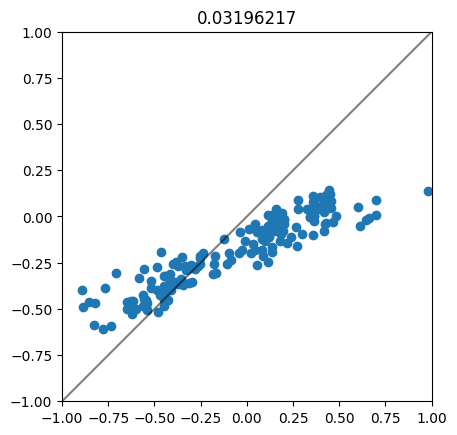

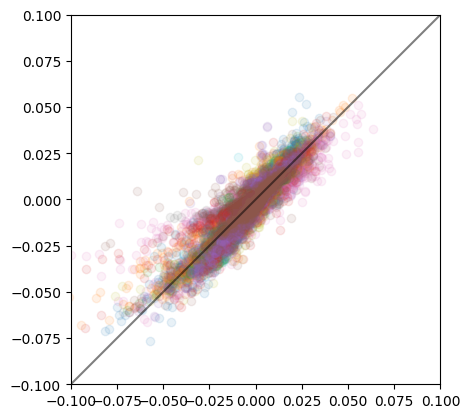

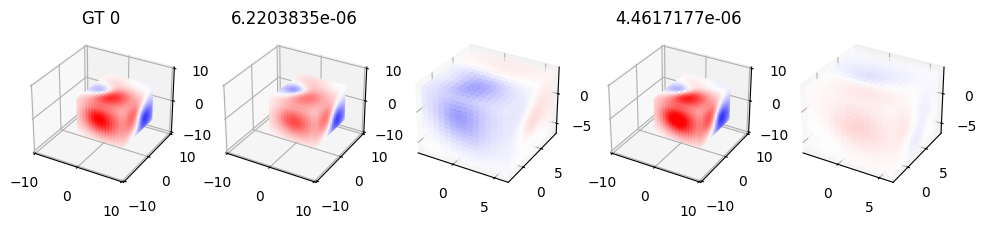

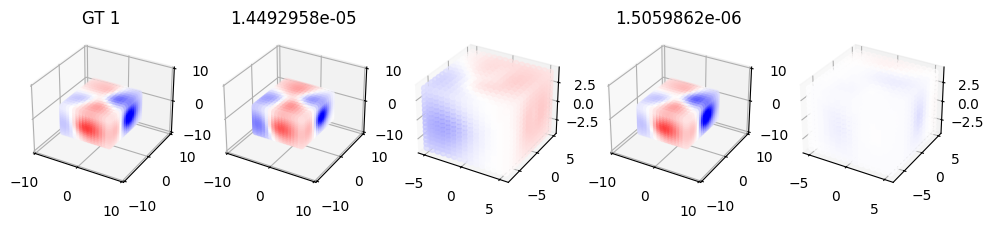

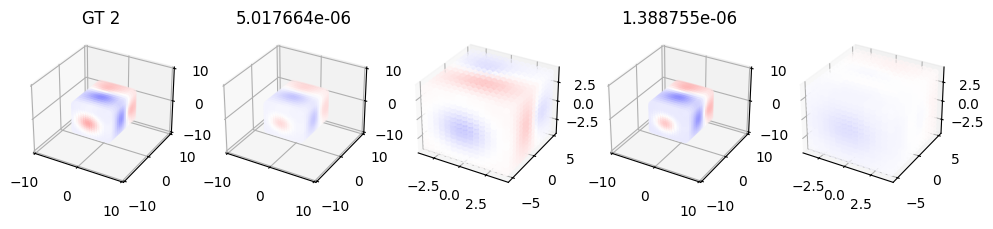

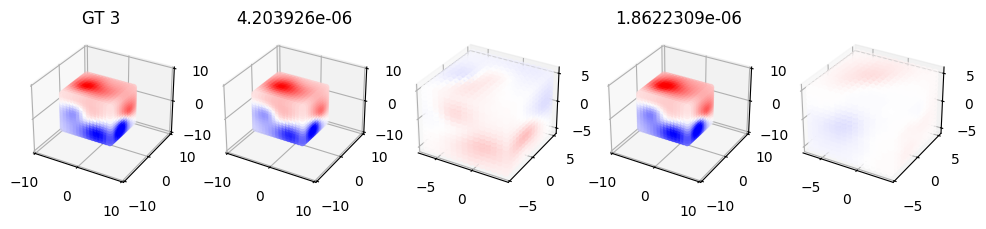

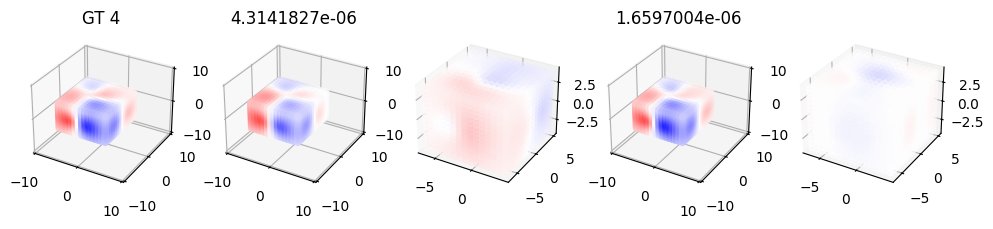

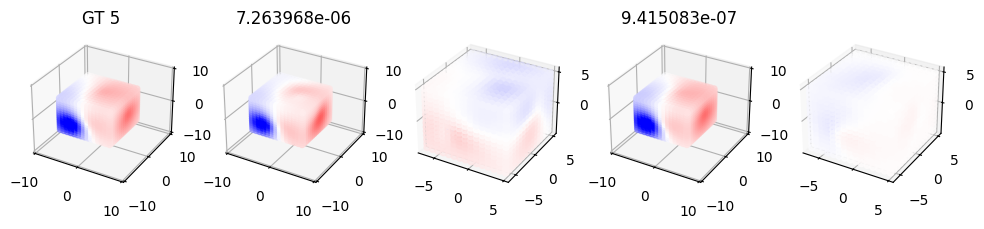

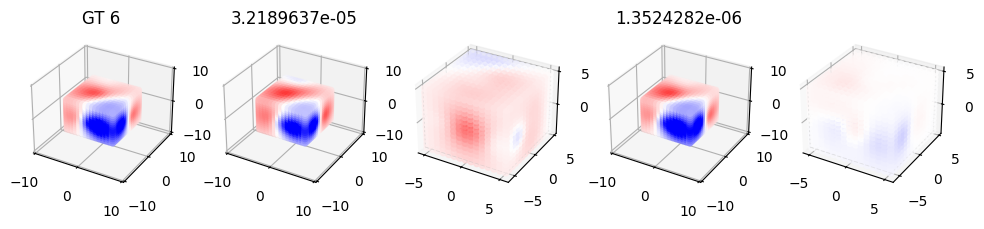

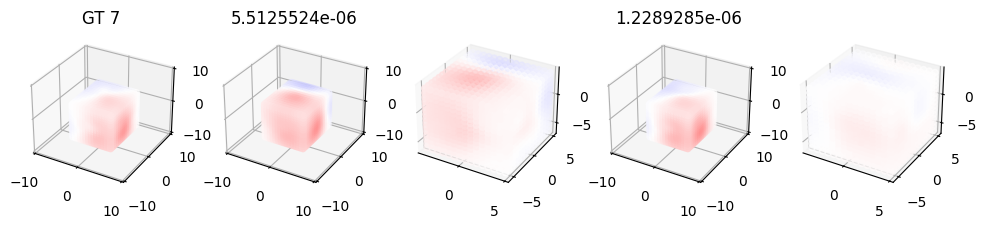

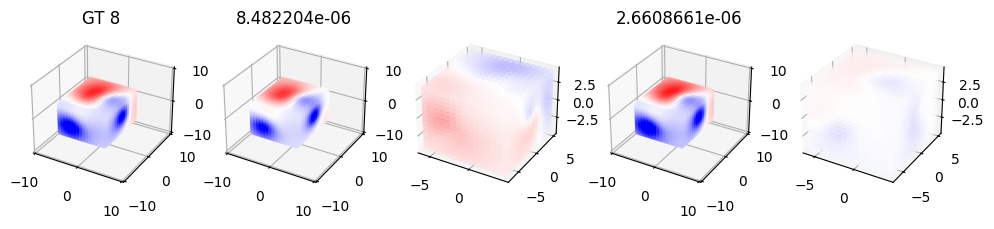

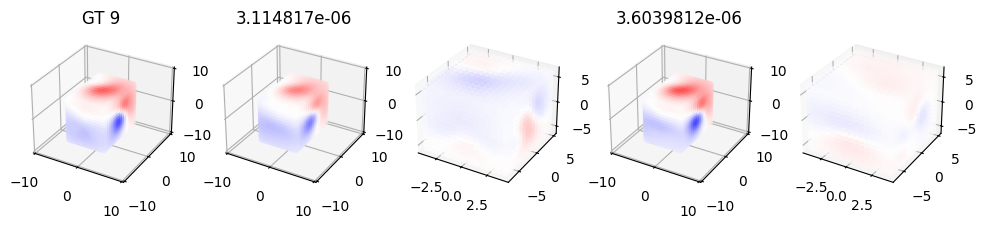

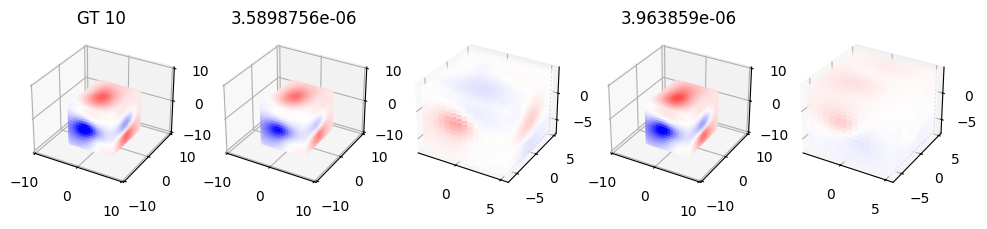

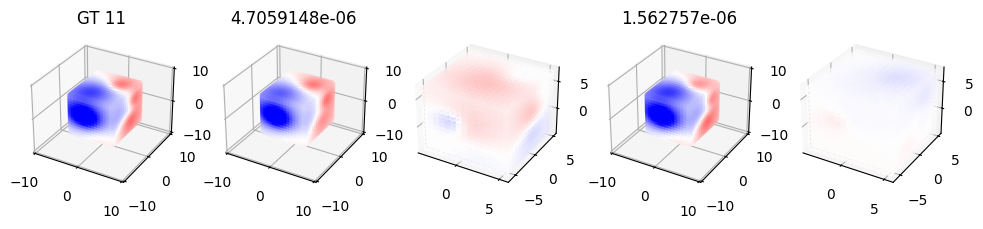

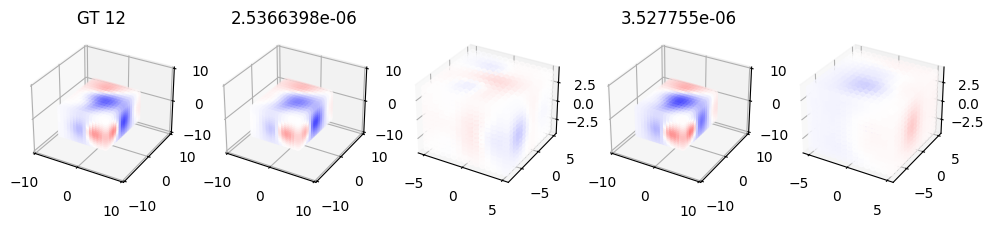

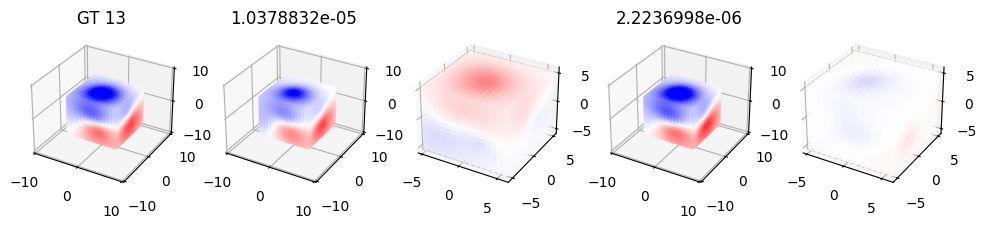

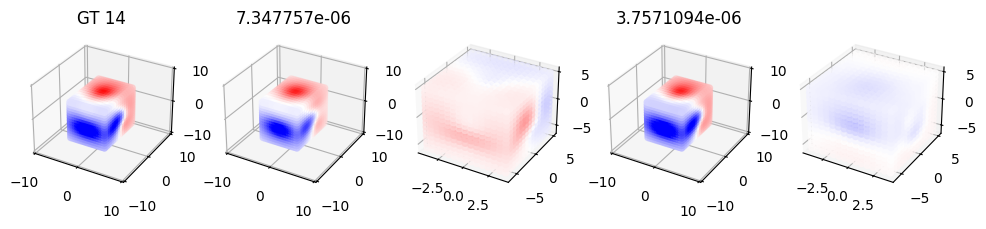

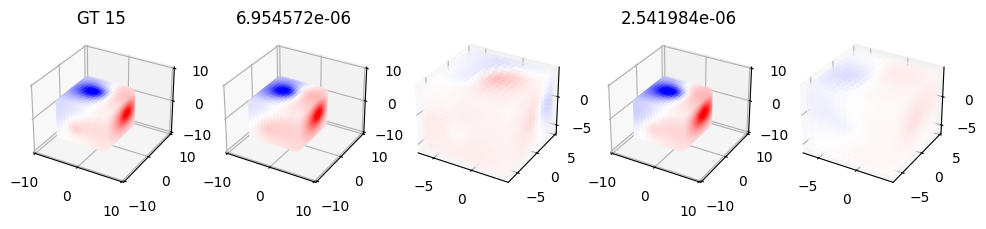

In [55]:
errors_train = []

for batchID in range(1):
    batch = valid_batches[batchID]
    
    mono, dipo = message_passing_model.apply(
        params,
        atomic_numbers=batch['atomic_numbers'],
        positions=batch['positions'],
        dst_idx=batch['dst_idx'],
        src_idx=batch['src_idx'],
        batch_segments=batch['batch_segments'],
        batch_size=batch_size
    )
    
    errors = evaluate_dc(batch, dipo, mono, batch_size, plot=True)
    errors_train.append(errors)

In [38]:
# errors_train

In [39]:
errors_test = []

for batchID in range(NTRAINEVAL):
    batch = train_batches[batchID]
    
    mono, dipo = message_passing_model.apply(
        params,
        atomic_numbers=batch['atomic_numbers'],
        positions=batch['positions'],
        dst_idx=batch['dst_idx'],
        src_idx=batch['src_idx'],
        batch_segments=batch['batch_segments'],
        batch_size=batch_size
    )
    
    errors = evaluate_dc(batch, dipo, mono, batch_size)
    errors_test.append(errors)

In [40]:
dcm1_errors = process_df(errors_test)

In [41]:
dcm1_errors.describe()

model        mono         dif
count  160.000000  160.000000  160.000000
mean     1.219799    0.991943    0.227856
std      0.386459    0.302645    0.335124
min      0.527225    0.576099   -0.577855
25%      0.941446    0.782169   -0.018301
50%      1.198431    0.930883    0.180911
75%      1.409905    1.102676    0.420157
max      2.599342    2.408691    1.617055

(0.0, 5.0)

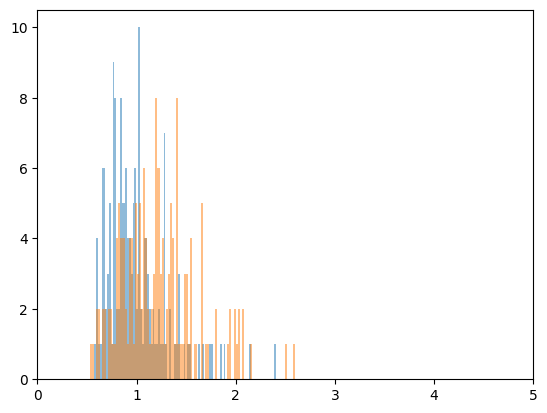

In [42]:
plt.hist(dcm1_errors["mono"], alpha=0.5, bins=100)
plt.hist(dcm1_errors["model"], alpha=0.5, bins=100)
plt.xlim(0, 5)

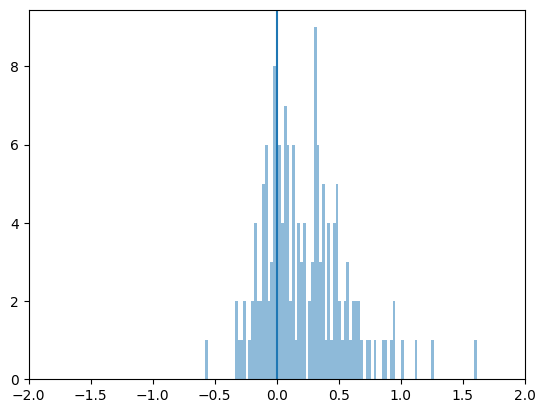

In [43]:
_ =  plt.hist(dcm1_errors["dif"], alpha=0.5, bins=100)
plt.xlim(-2,2)
plt.axvline(0)

# DCM2

In [141]:
# Model hyperparameters.
features = 32
max_degree = 2
num_iterations = 3
num_basis_functions = 16
cutoff = 4.0

n_dcm = 2
# Training hyperparameters.
learning_rate = 0.001
batch_size = 16
esp_w = 10.0
restart_params = None
num_epochs = 20

# Create and train model.
message_passing_model = MessagePassingModel(
    features=features,
    max_degree=max_degree,
    num_iterations=num_iterations,
    num_basis_functions=num_basis_functions,
    cutoff=cutoff,
    n_dcm=n_dcm,
)

params = pd.read_pickle("checkpoints/dcm2-10000.0/1-0.038391292095184326-esp_params.pkl")

# params = pd.read_pickle("checkpoints/dcm2-10000.0/7-0.0513247549533844-esp_params.pkl")
# params = pd.read_pickle("checkpoints/dcm2-10.0/99-0.00013578754442278296-esp_params.pkl")

# params = pd.read_pickle("checkpoints/dcm2-1000.0/1-0.005339722149074078-esp_params.pkl")
# params = pd.read_pickle("checkpoints/dcm2-1000.0/26-0.008979301899671555-esp_params.pkl")

# params = pd.read_pickle("checkpoints/dcm2-100.0/25-0.0007704171002842486-esp_params.pkl")



message_passing_model

MessagePassingModel(
    # attributes
    features = 32
    max_degree = 2
    num_iterations = 3
    num_basis_functions = 16
    cutoff = 4.0
    max_atomic_number = 17
    n_dcm = 2
)

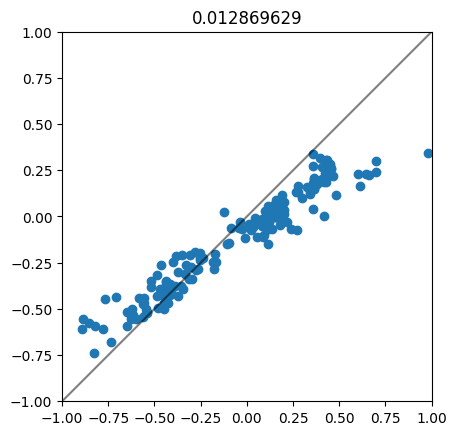

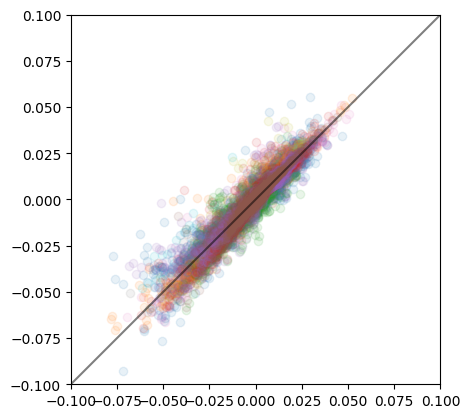

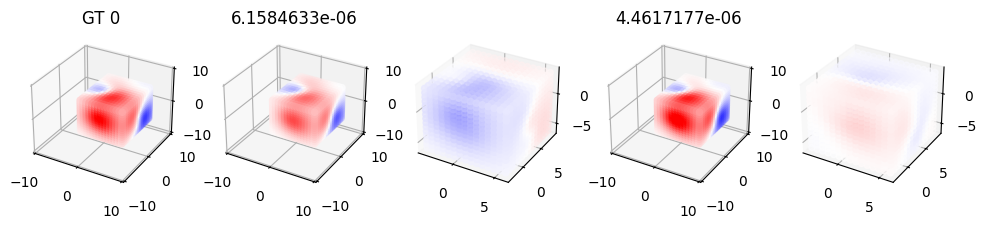

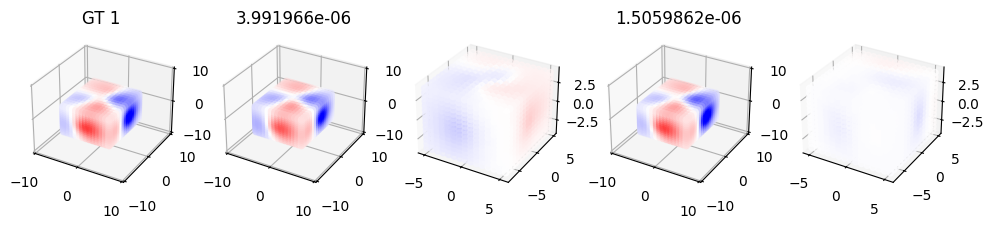

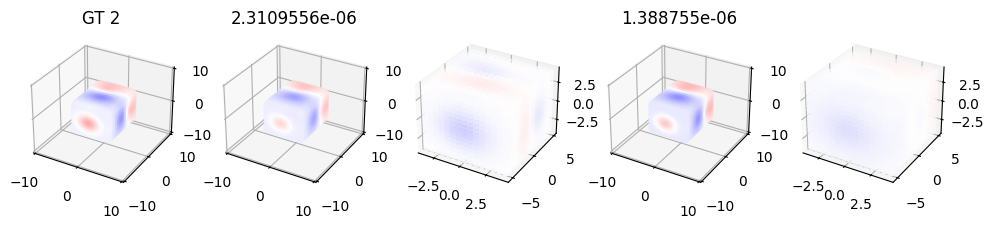

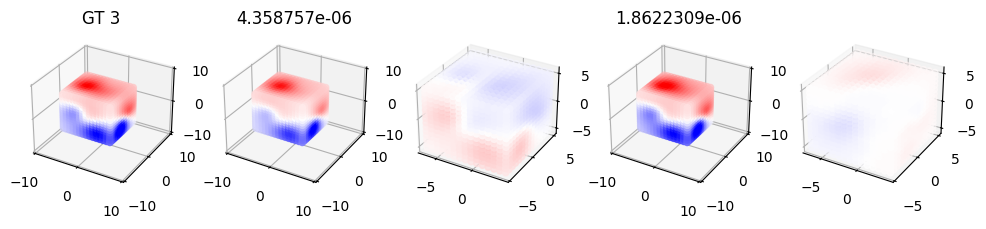

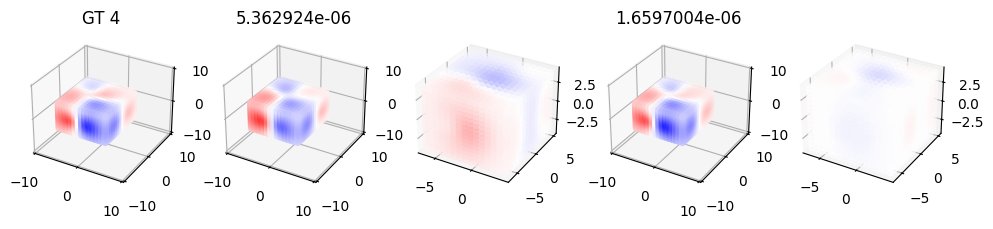

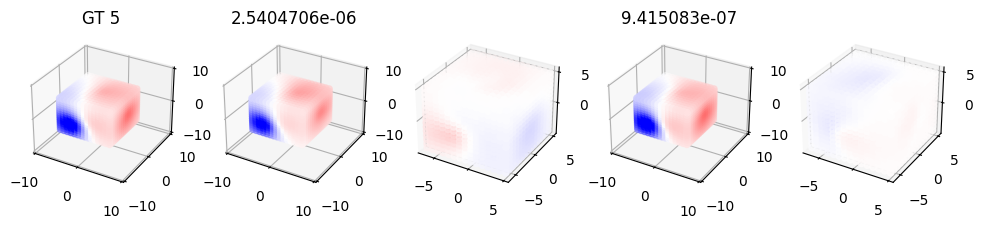

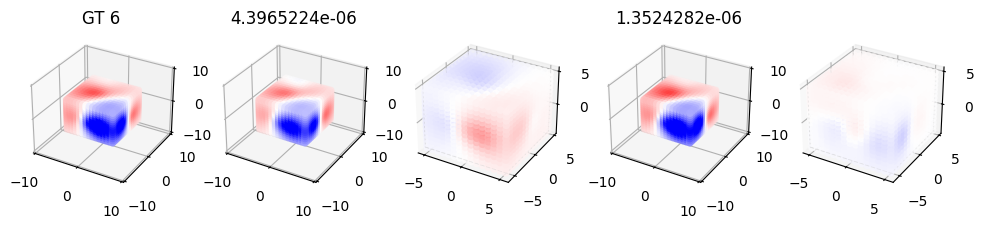

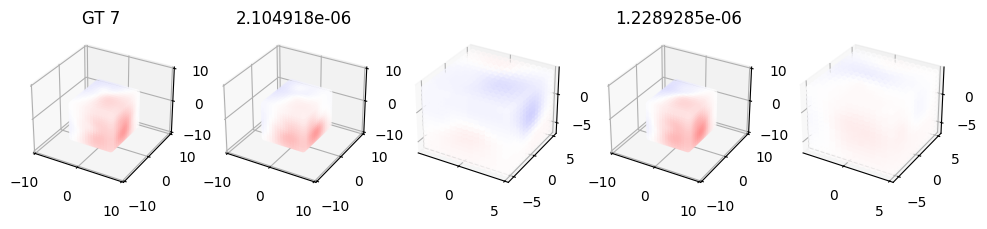

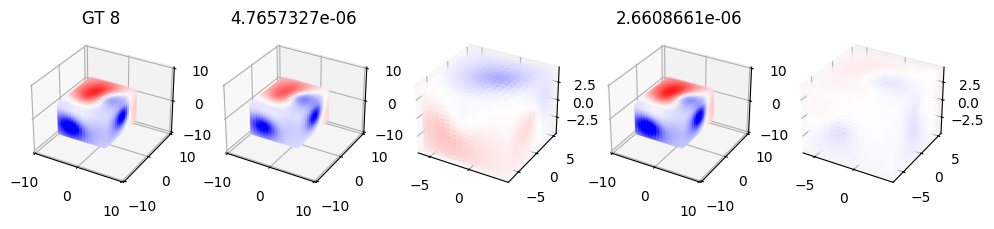

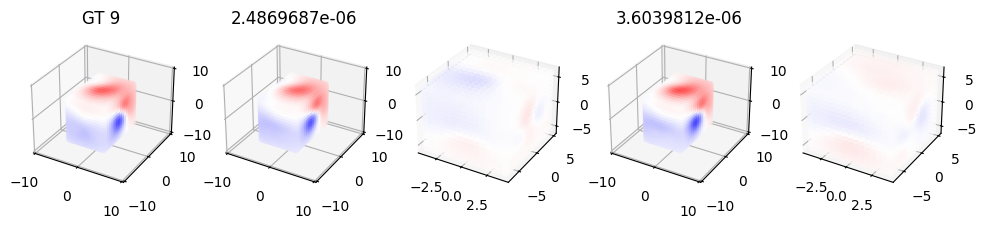

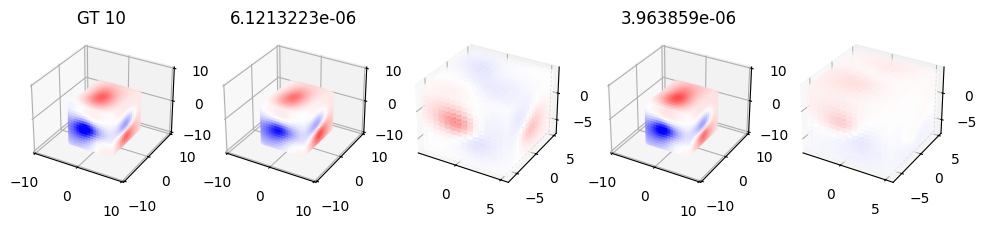

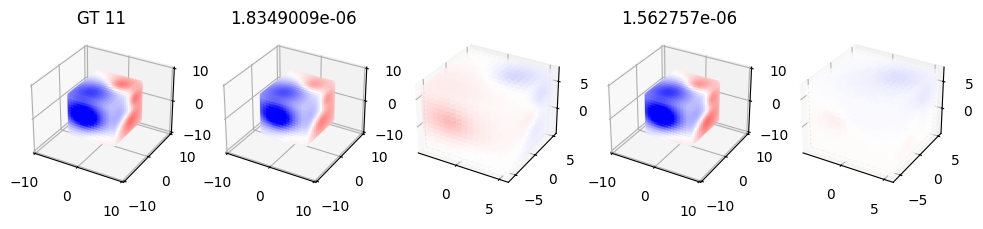

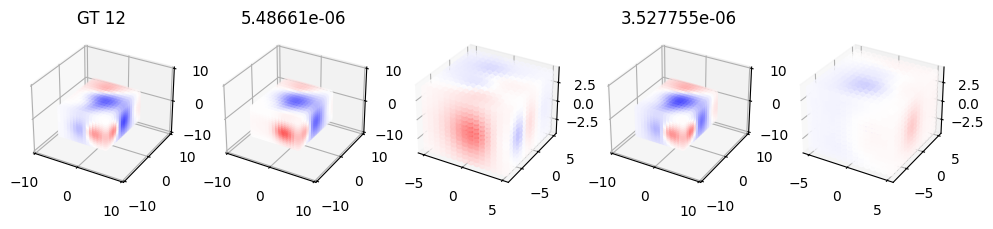

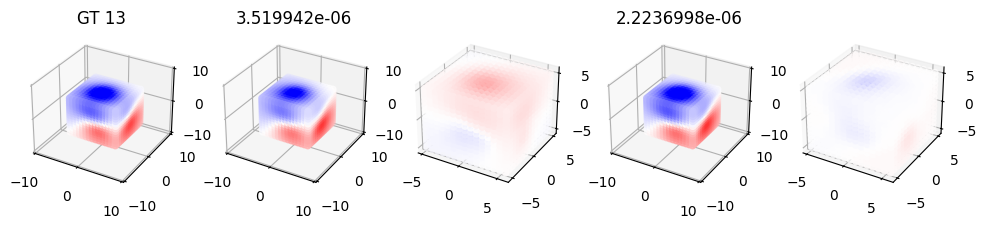

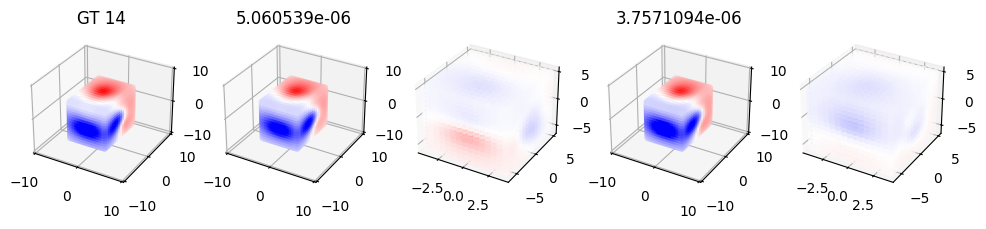

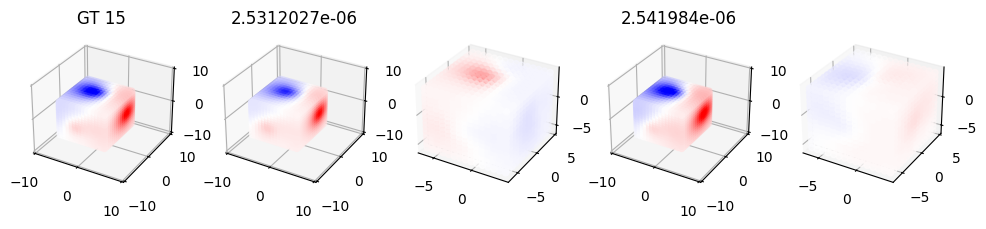

In [142]:
for batchID in range(1):
    batch = valid_batches[batchID]
    
    mono, dipo = message_passing_model.apply(
        params,
        atomic_numbers=batch['atomic_numbers'],
        positions=batch['positions'],
        dst_idx=batch['dst_idx'],
        src_idx=batch['src_idx'],
        batch_segments=batch['batch_segments'],
        batch_size=batch_size
    )
    
    evaluate_dc(batch, dipo, mono, batch_size, plot=True)

In [144]:
test_error = []

for batchID in range(NTRAINEVAL):
    batch = train_batches[batchID]
    
    mono, dipo = message_passing_model.apply(
        params,
        atomic_numbers=batch['atomic_numbers'],
        positions=batch['positions'],
        dst_idx=batch['dst_idx'],
        src_idx=batch['src_idx'],
        batch_segments=batch['batch_segments'],
        batch_size=batch_size
    )
    
    error = evaluate_dc(batch, dipo, mono, batch_size)
    test_error.append(error)

In [145]:
dcm2_errors = process_df(test_error)

In [146]:
dcm2_errors.describe()

model        mono         dif
count  160.000000  160.000000  160.000000
mean     1.070061    0.991943    0.078118
std      0.442643    0.302645    0.318139
min      0.481582    0.576099   -0.633712
25%      0.774525    0.782169   -0.113301
50%      0.979792    0.930883    0.030859
75%      1.191975    1.102676    0.196936
max      3.181410    2.408691    1.427381

(0.0, 5.0)

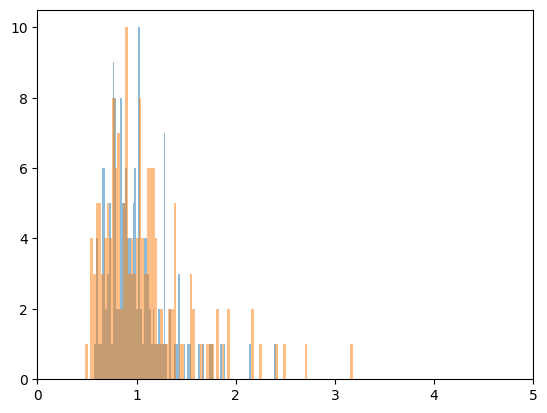

In [147]:
plt.hist(dcm2_errors["mono"], alpha=0.5, bins=100)
plt.hist(dcm2_errors["model"], alpha=0.5, bins=100)
plt.xlim(0, 5)

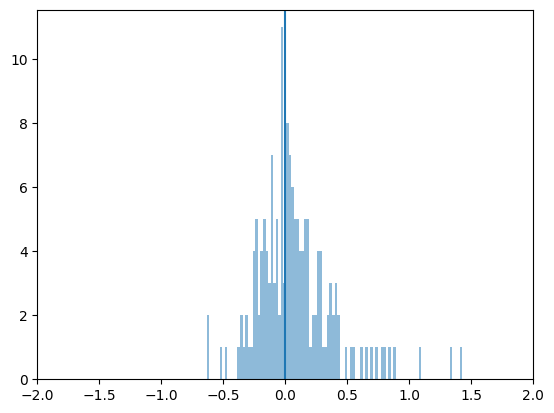

In [148]:
_ =  plt.hist(dcm2_errors["dif"], alpha=0.5, bins=100)
plt.xlim(-2,2)
plt.axvline(0)

#  DCM3

In [164]:
# Model hyperparameters.
features = 32
max_degree = 2
num_iterations = 3
num_basis_functions = 16
cutoff = 4.0

n_dcm = 3
# Training hyperparameters.
learning_rate = 0.001
batch_size = 16
esp_w = 10.0
restart_params = None
num_epochs = 20

# Create and train model.
message_passing_model = MessagePassingModel(
    features=features,
    max_degree=max_degree,
    num_iterations=num_iterations,
    num_basis_functions=num_basis_functions,
    cutoff=cutoff,
    n_dcm=n_dcm,
)

params = pd.read_pickle("checkpoints/dcm3-10000.0/0-0.019015571102499962-esp_params.pkl")
# params = pd.read_pickle("checkpoints/dcm3-10.0/17-0.0001334990083705634-esp_params.pkl")
# params = pd.read_pickle("checkpoints/dcm3-1000.0/26-0.0028469625394791365-esp_params.pkl")
# params = pd.read_pickle("checkpoints/dcm3-100.0/14-0.0007971551967784762-esp_params.pkl")
message_passing_model

MessagePassingModel(
    # attributes
    features = 32
    max_degree = 2
    num_iterations = 3
    num_basis_functions = 16
    cutoff = 4.0
    max_atomic_number = 17
    n_dcm = 3
)

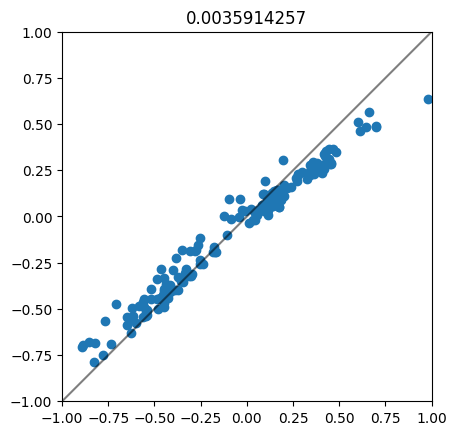

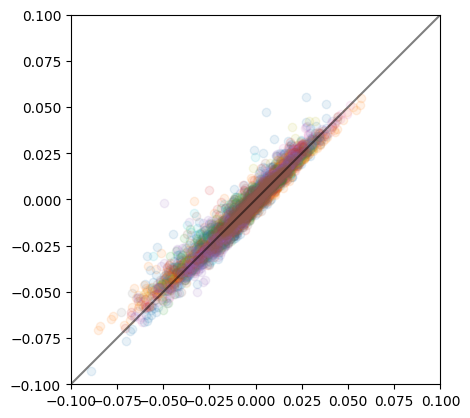

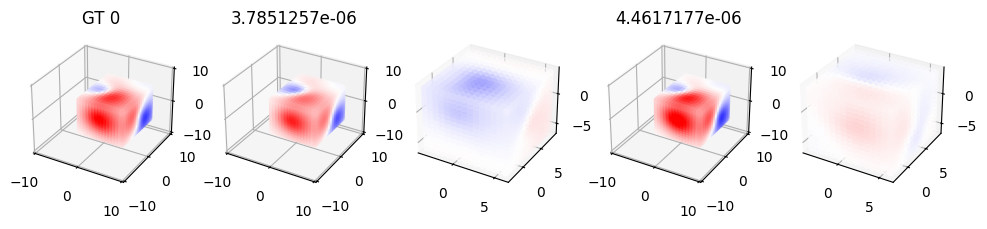

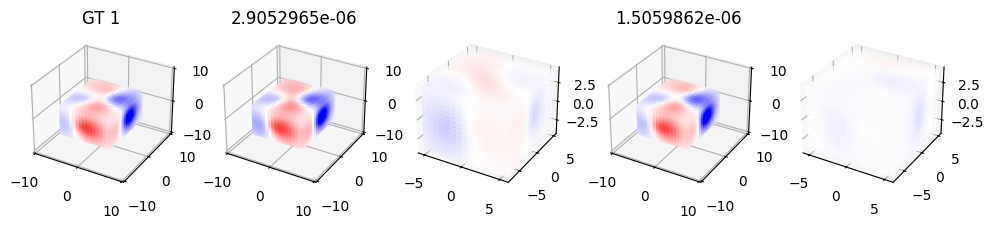

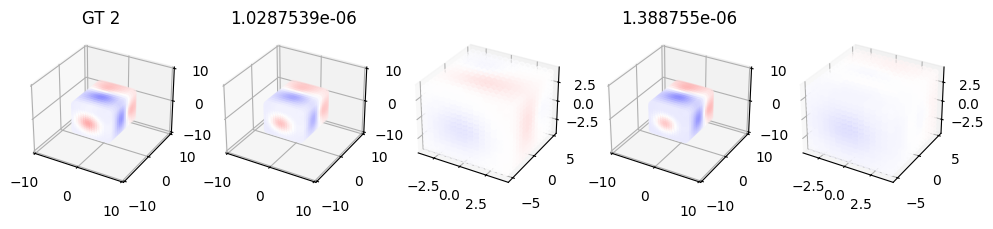

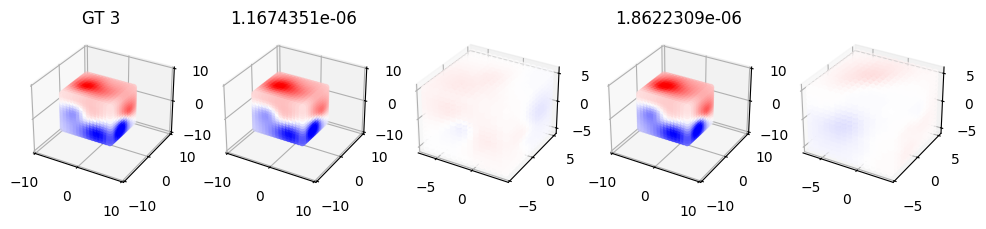

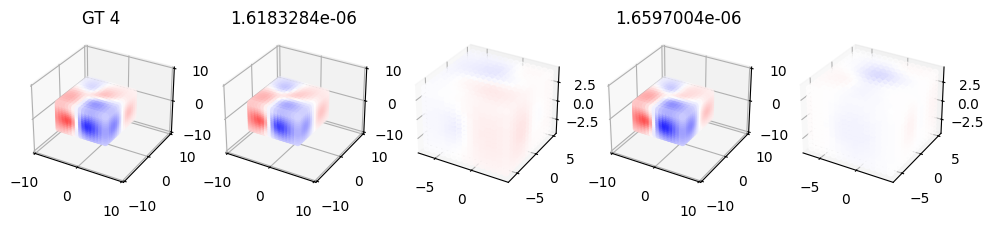

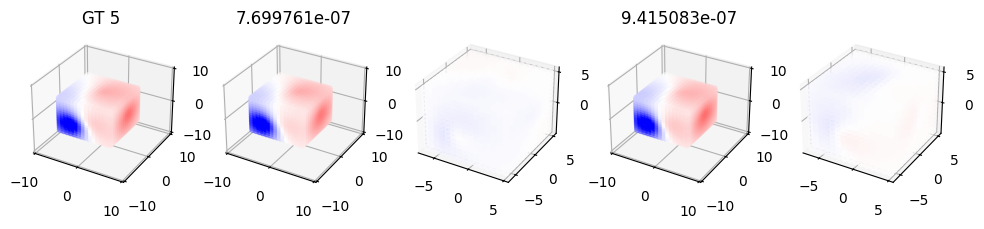

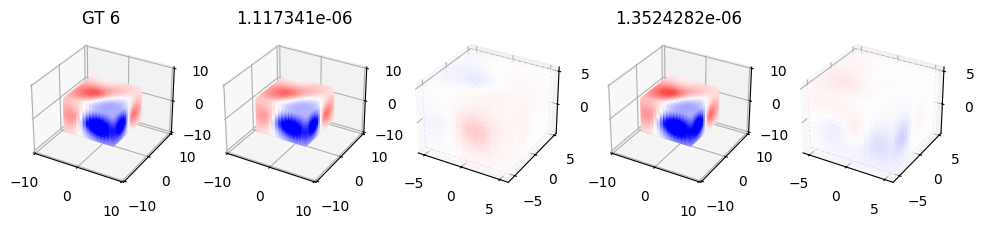

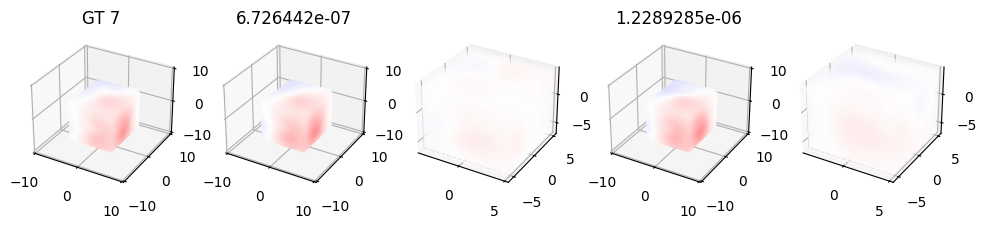

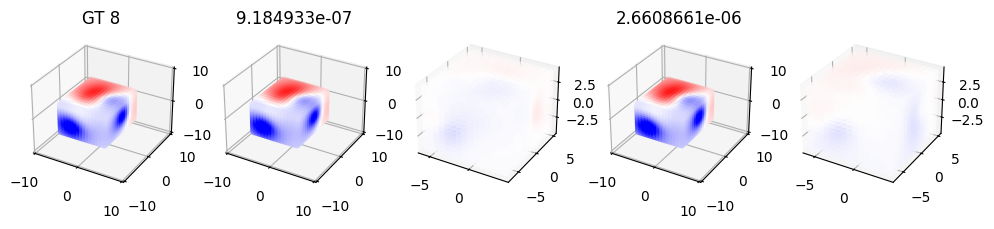

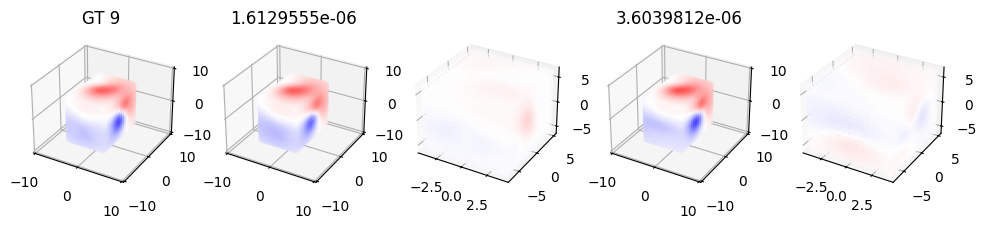

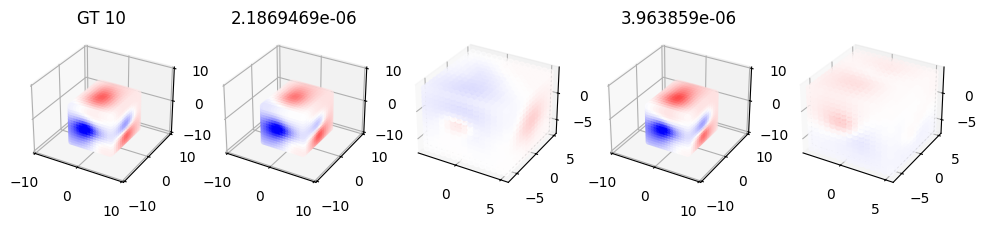

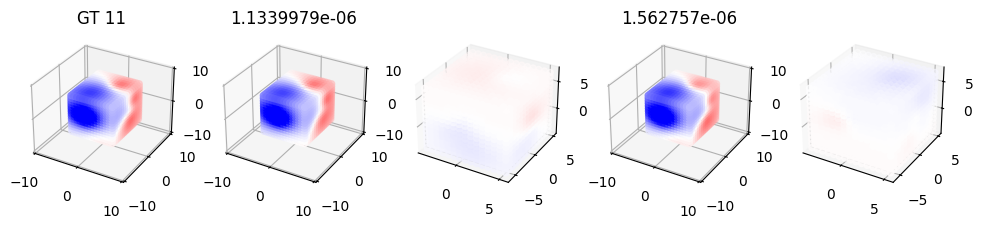

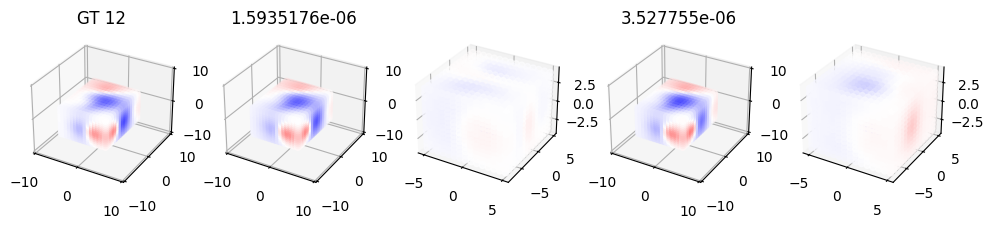

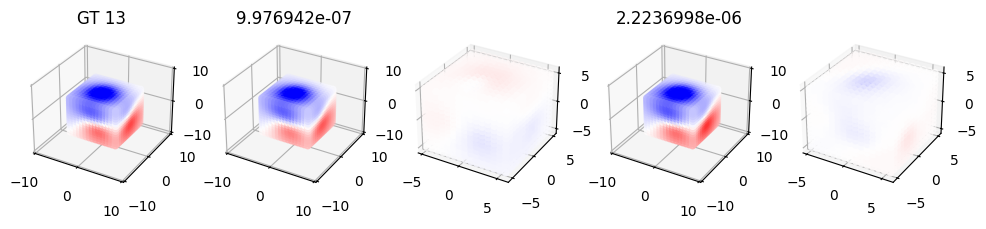

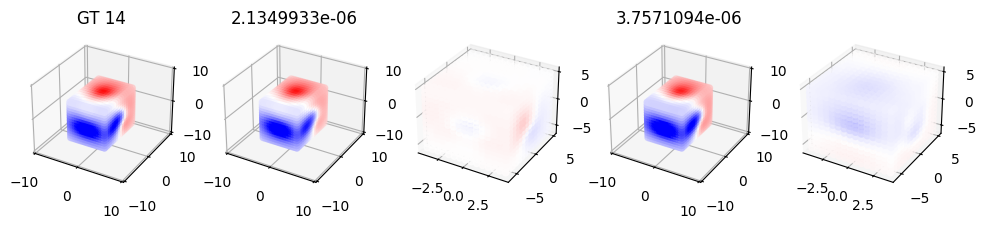

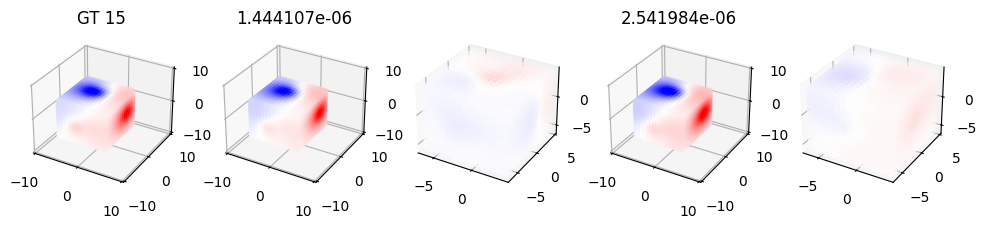

In [165]:
for batchID in range(1):
    batch = valid_batches[batchID]
    
    mono, dipo = message_passing_model.apply(
        params,
        atomic_numbers=batch['atomic_numbers'],
        positions=batch['positions'],
        dst_idx=batch['dst_idx'],
        src_idx=batch['src_idx'],
        batch_segments=batch['batch_segments'],
        batch_size=batch_size
    )
    
    evaluate_dc(batch, dipo, mono, batch_size, plot=True)

In [166]:
test_errors = []

for batchID in range(NTRAINEVAL):
    batch = train_batches[batchID]
    
    mono, dipo = message_passing_model.apply(
        params,
        atomic_numbers=batch['atomic_numbers'],
        positions=batch['positions'],
        dst_idx=batch['dst_idx'],
        src_idx=batch['src_idx'],
        batch_segments=batch['batch_segments'],
        batch_size=batch_size
    )
    
    errors = evaluate_dc(batch, dipo, mono, batch_size)
    test_errors.append(errors)

In [167]:
dcm3_errors = process_df(test_errors)

In [168]:
dcm3_errors.describe()

model        mono         dif
count  160.000000  160.000000  160.000000
mean     0.792223    0.991943   -0.199720
std      0.331617    0.302645    0.241301
min      0.283803    0.576099   -0.835110
25%      0.557685    0.782169   -0.336694
50%      0.701415    0.930883   -0.228588
75%      0.933946    1.102676   -0.098732
max      2.086090    2.408691    0.687874

(0.0, 5.0)

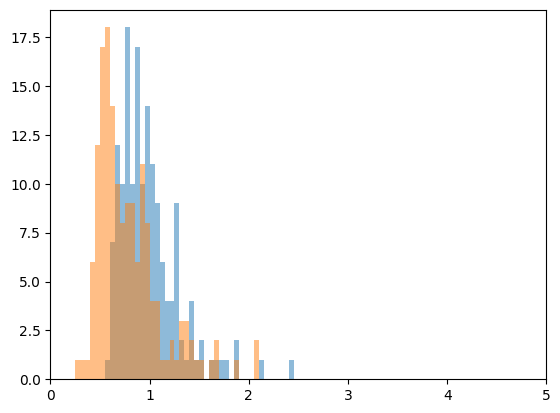

In [169]:
plt.hist(dcm3_errors["mono"], alpha=0.5, bins=100, range=(0,5))
plt.hist(dcm3_errors["model"], alpha=0.5, bins=100, range=(0,5))
plt.xlim(0, 5)

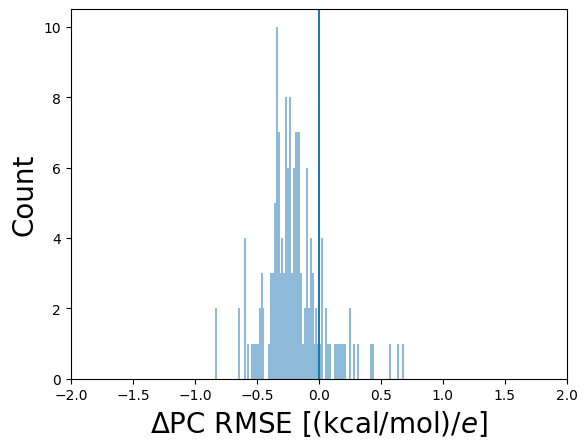

In [170]:
_ =  plt.hist(dcm3_errors["dif"], alpha=0.5, bins=100)
plt.xlim(-2,2)
plt.axvline(0)
plt.ylabel("Count", fontsize=20)
plt.xlabel("$\Delta$PC RMSE [(kcal/mol)/$e$]", fontsize=20)
plt.savefig("deltaESP-dcm3.pdf", bbox_inches="tight")

#  DCM4

In [149]:
# Model hyperparameters.
features = 32
max_degree = 2
num_iterations = 3
num_basis_functions = 16
cutoff = 4.0

n_dcm = 4
# Training hyperparameters.
learning_rate = 0.001
batch_size = 16
esp_w = 10.0
restart_params = None
num_epochs = 20

# Create and train model.
message_passing_model = MessagePassingModel(
    features=features,
    max_degree=max_degree,
    num_iterations=num_iterations,
    num_basis_functions=num_basis_functions,
    cutoff=cutoff,
    n_dcm=n_dcm,
)

params = pd.read_pickle("checkpoints/dcm4-10000.0/0-0.015613120049238205-esp_params.pkl")

# params = pd.read_pickle("checkpoints/dcm4-10.0/25-0.00011416388588258997-esp_params.pkl")

# params = pd.read_pickle("checkpoints/dcm4-100.0/14-0.0007527425768785179-esp_params.pkl")
# 

message_passing_model

MessagePassingModel(
    # attributes
    features = 32
    max_degree = 2
    num_iterations = 3
    num_basis_functions = 16
    cutoff = 4.0
    max_atomic_number = 17
    n_dcm = 4
)

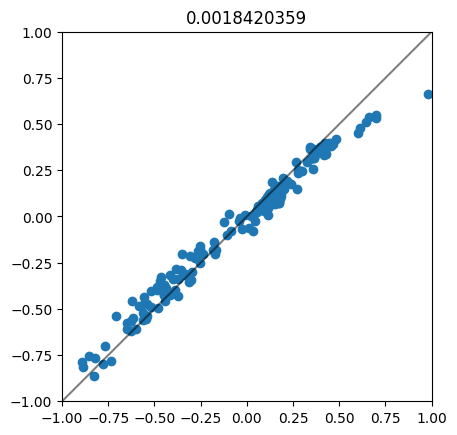

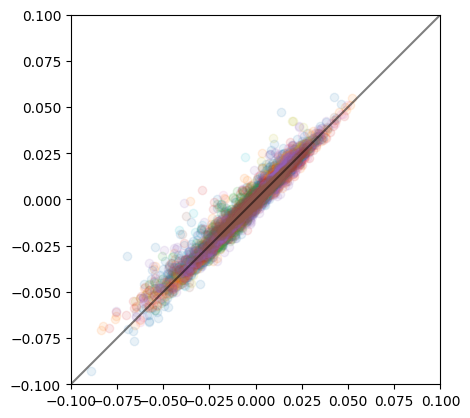

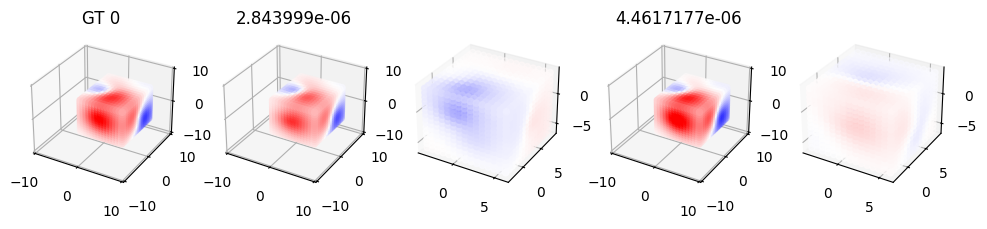

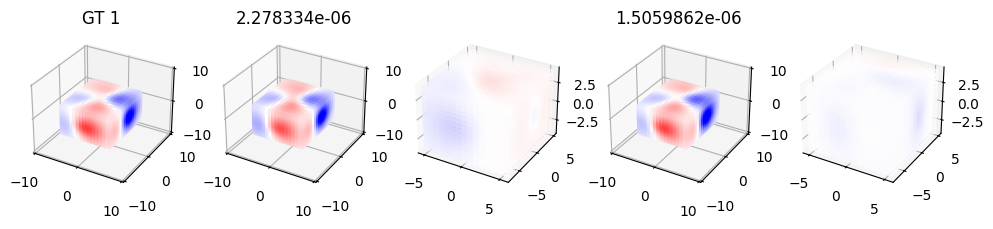

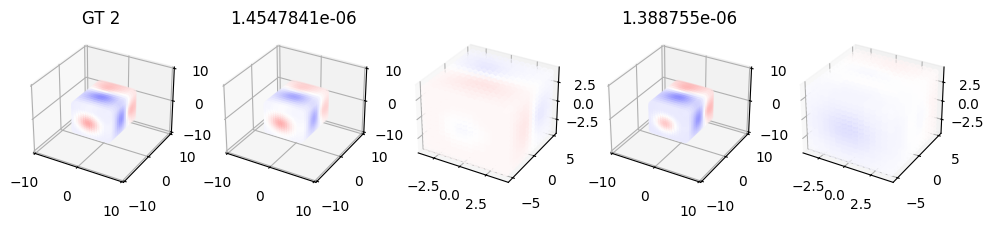

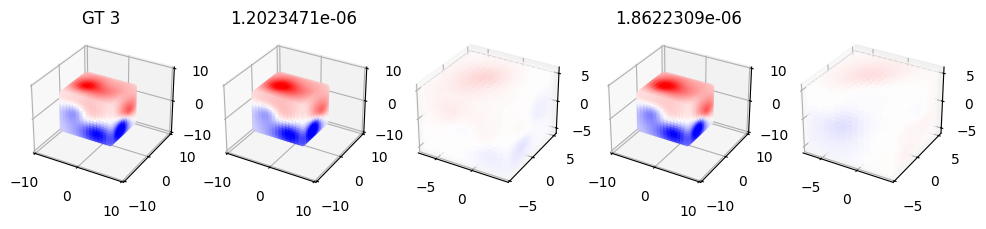

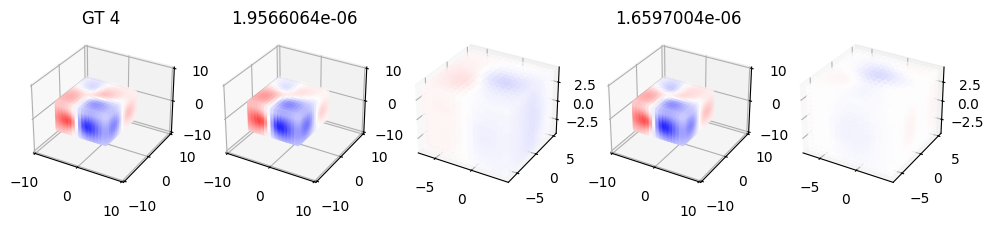

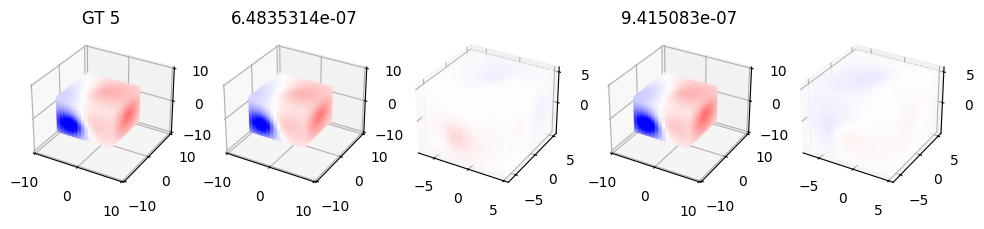

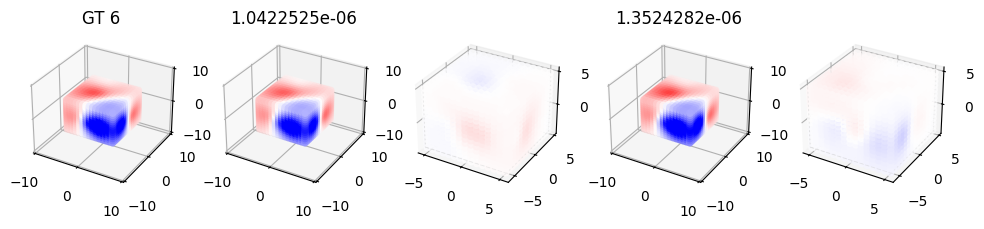

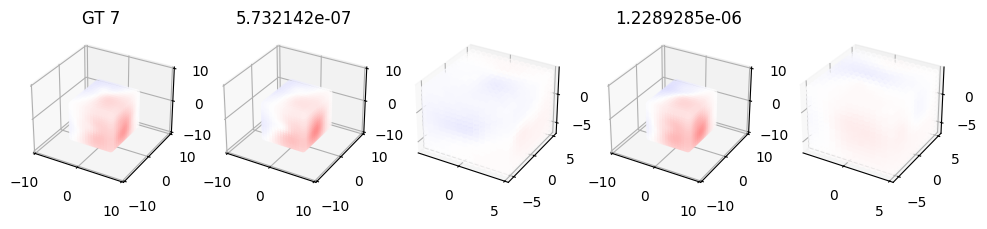

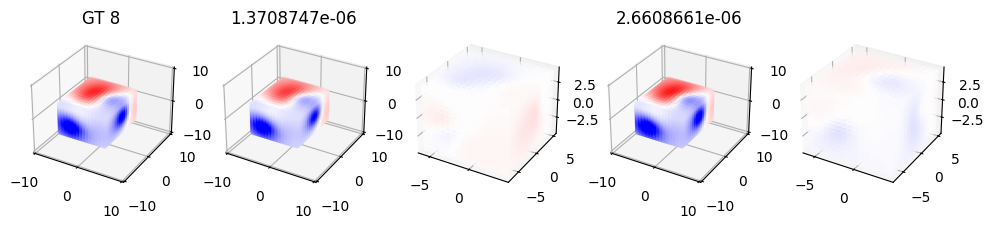

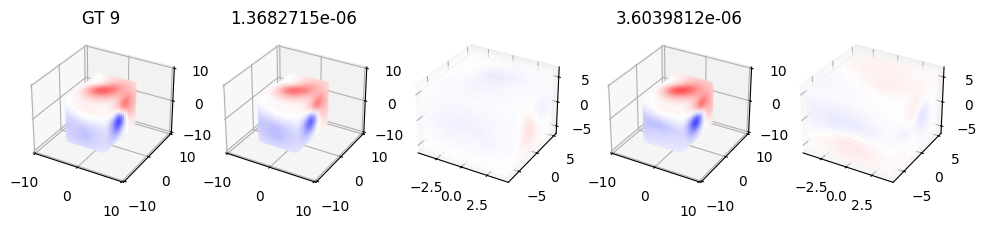

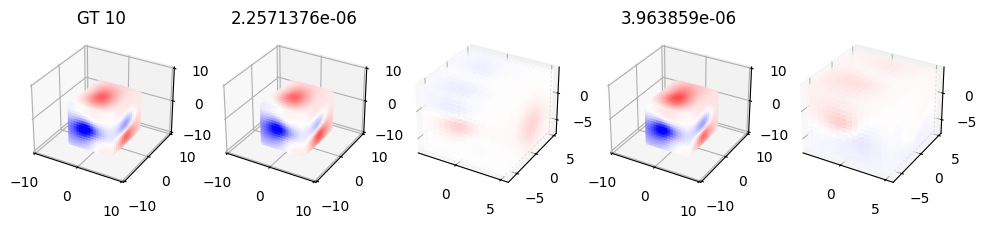

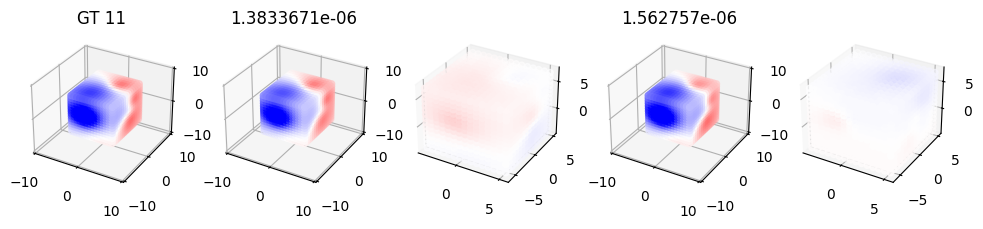

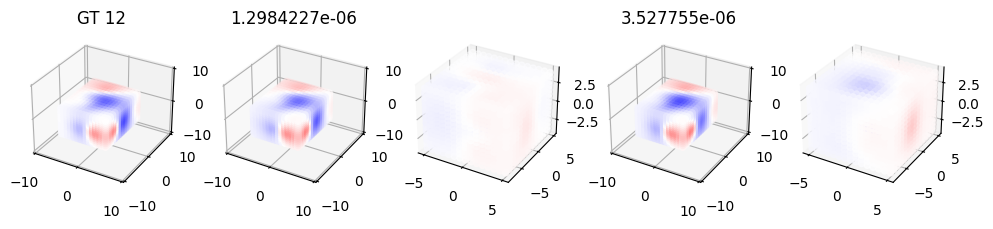

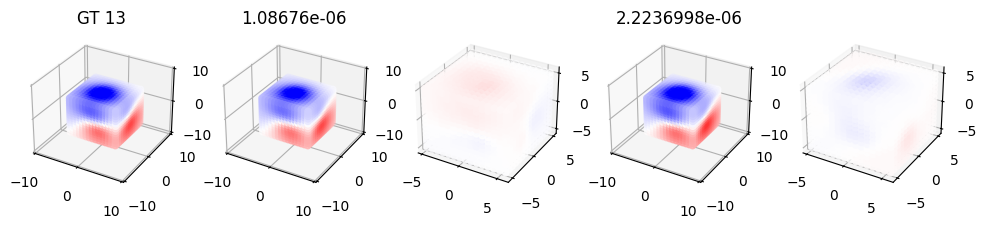

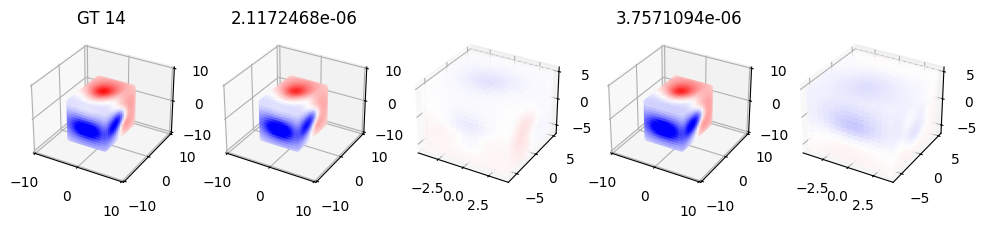

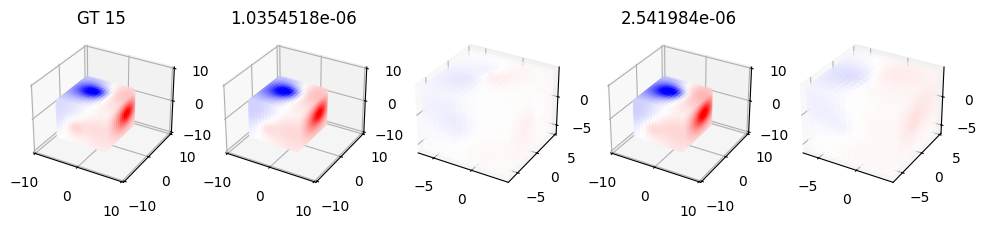

In [150]:
for batchID in range(1):
    batch = valid_batches[batchID]
    
    mono, dipo = message_passing_model.apply(
        params,
        atomic_numbers=batch['atomic_numbers'],
        positions=batch['positions'],
        dst_idx=batch['dst_idx'],
        src_idx=batch['src_idx'],
        batch_segments=batch['batch_segments'],
        batch_size=batch_size
    )
    
    evaluate_dc(batch, dipo, mono, batch_size, plot=True)

In [151]:
test_errors = []

for batchID in range(NTRAINEVAL):
    batch = train_batches[batchID]
    
    mono, dipo = message_passing_model.apply(
        params,
        atomic_numbers=batch['atomic_numbers'],
        positions=batch['positions'],
        dst_idx=batch['dst_idx'],
        src_idx=batch['src_idx'],
        batch_segments=batch['batch_segments'],
        batch_size=batch_size
    )
    
    errors = evaluate_dc(batch, dipo, mono, batch_size)
    test_errors.append(errors)

In [152]:
dcm4_errors = process_df(test_errors)

In [153]:
dcm4_errors.describe()

model        mono         dif
count  160.000000  160.000000  160.000000
mean     0.720024    0.991943   -0.271919
std      0.260041    0.302645    0.272651
min      0.324340    0.576099   -1.486610
25%      0.534372    0.782169   -0.410139
50%      0.672677    0.930883   -0.279510
75%      0.831526    1.102676   -0.146008
max      1.820106    2.408691    0.987243

(0.0, 5.0)

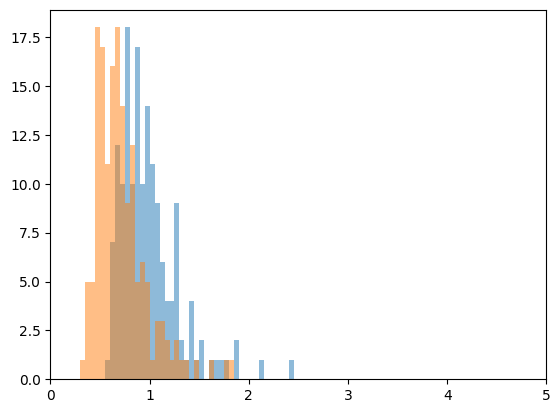

In [154]:
plt.hist(dcm4_errors["mono"], alpha=0.5, bins=100, range=(0,5))
plt.hist(dcm4_errors["model"], alpha=0.5, bins=100, range=(0,5))
plt.xlim(0, 5)

Text(0.5, 0, '$\\Delta$PC RMSE [(kcal/mol)/$e$]')

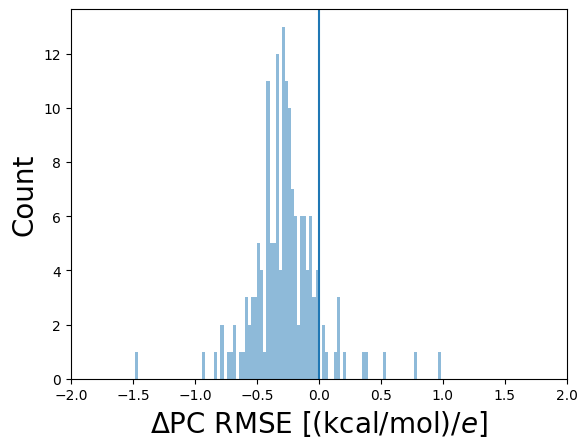

In [155]:
_ =  plt.hist(dcm4_errors["dif"], alpha=0.5, bins=100)
plt.xlim(-2,2)
plt.axvline(0)
plt.ylabel("Count", fontsize=20)
plt.xlabel("$\Delta$PC RMSE [(kcal/mol)/$e$]", fontsize=20)

#  Structures

In [61]:
i = 1
a1_ = mono.reshape(batch_size, 60, n_dcm)[i]
b1_ = batch['atomic_numbers'].reshape(batch_size, 60)[i]
c1_ = batch["mono"].reshape(batch_size, 60)[i]
nonzero = np.nonzero(c1_)

total = 0.0
total_mono = 0.0

for j, l, k in zip(a1_[nonzero], b1_[nonzero], c1_[nonzero]):
    print(j, j.sum(), l, k, abs(j.sum() - k))
    total += j.sum()
    total_mono += k
    
print(total, total_mono)
dc = dipo.reshape(batch_size,60,3,n_dcm)
dc = np.moveaxis(dc, -1, -2)
dc = dc.reshape(batch_size, 60*n_dcm, 3)
dcq = mono.reshape(batch_size,60*n_dcm,1)
dcq = np.moveaxis(dcq, -1, -2)
dcq = dcq.reshape(batch_size, 60*n_dcm, 1)

[-0.41315448] -0.41315448 6 -0.44604227 0.032887787
[-0.18291636] -0.18291636 6 -0.02394517 0.15897119
[-0.26352513] -0.26352513 6 -0.3048267 0.04130158
[-0.05395494] -0.053954944 6 0.61452305 0.668478
[-0.5912091] -0.5912091 7 -0.7329903 0.14178121
[-0.30406862] -0.30406862 7 -0.7071981 0.40312946
[0.01061848] 0.010618478 6 0.69609046 0.685472
[-0.50514877] -0.50514877 8 -0.5393988 0.03425002
[-0.07352336] -0.07352336 1 0.17009626 0.24361962
[-0.00938273] -0.009382734 1 0.15997593 0.16935867
[-0.07922909] -0.079229094 1 0.17010091 0.24933001
[-0.02143143] -0.021431427 1 0.19899754 0.22042897
[-0.00445965] -0.0044596517 1 0.3402381 0.34469774
[0.05494366] 0.05494366 1 0.40438256 0.3494389
-2.4364417 3.4868717e-06


In [62]:
xyz = batch['positions'].reshape(batch_size,60,3)[i][nonzero]
elem = batch["atomic_numbers"].reshape(batch_size,60)[i][nonzero]
from ase import Atoms
from ase.visualize import view
mol = Atoms(elem, xyz)
view(mol, viewer="x3d")

In [63]:
idx = len(nonzero[0])*n_dcm
dcmol = Atoms(["X" if _ > 0 else "He" for _ in dcq[i][:idx]], dc[i][:idx])
view(dcmol, viewer="x3d")

In [64]:
combined = dcmol + mol
view(combined, viewer="x3d")

In [65]:
(dipo - batch['positions'][:,:,None]).reshape(batch_size, 60, 3, n_dcm)[i][nonzero]

Array([[[-9.3306959e-02],
        [ 3.3626342e-01],
        [-2.4224030e-02]],

       [[ 1.1088279e-01],
        [-2.6362296e-04],
        [ 3.3696815e-02]],

       [[-4.1150808e-01],
        [ 1.8054134e-01],
        [-7.3730513e-02]],

       [[-1.8426287e-01],
        [-3.1013918e-01],
        [-2.5743380e-02]],

       [[-7.3976195e-01],
        [ 8.1641674e-03],
        [-1.1096968e-01]],

       [[ 3.4736037e-02],
        [ 1.2421632e-01],
        [ 2.4188310e-03]],

       [[ 5.4222274e-01],
        [ 5.2288675e-01],
        [ 7.7740341e-02]],

       [[ 3.1216908e-01],
        [ 9.2187226e-02],
        [ 4.2252094e-02]],

       [[-9.1224253e-02],
        [ 3.1693339e-02],
        [ 1.8198127e-01]],

       [[ 2.2713268e-01],
        [ 1.1541009e-02],
        [ 3.4394518e-02]],

       [[-3.1755060e-02],
        [ 2.7349710e-02],
        [-1.9862354e-01]],

       [[-1.7285824e-02],
        [-3.7012994e-02],
        [-1.0387003e-03]],

       [[-2.6724935e-03],
        [-9.53

# Equivariance 

In [77]:
key, rotation_key = jax.random.split(data_key)
rotation = e3x.so3.random_rotation(rotation_key, perturbation=1) 
rotation



Array([[ 0.05267996,  0.32747048, -0.9433917 ],
       [ 0.91801924, -0.38768542, -0.08331037],
       [-0.39302087, -0.861663  , -0.32104754]], dtype=float32)

In [78]:
for batchID in range(1):
    batch = train_batches[batchID]
    
    mono_rot, dipo_rot = message_passing_model.apply(
        params,
        atomic_numbers=batch['atomic_numbers'],
        positions=batch['positions']@rotation,
        dst_idx=batch['dst_idx'],
        src_idx=batch['src_idx'],
        batch_segments=batch['batch_segments'],
        batch_size=batch_size
    )
    
    # evaluate_dc(batch, dipo, mono, batch_size)

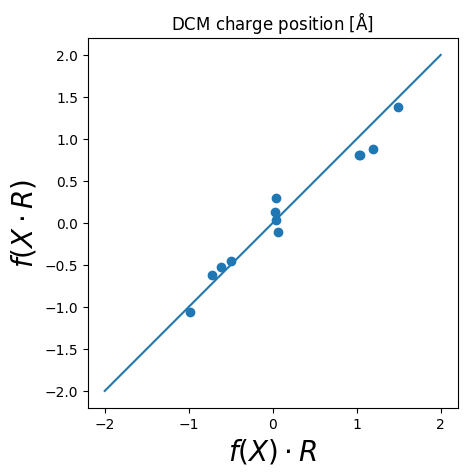

In [79]:
plt.scatter((dipo[0].T  @ rotation).flatten(), dipo_rot[0].T.flatten() )
plt.plot([-2,2],[-2,2])
# plt.xlim(-1.25,1.25)
# plt.ylim(-1.25,1.25)
plt.xlabel('$f(X) \cdot R$', fontsize=20)
plt.ylabel('$f(X \cdot R)$', fontsize=20)
plt.title("DCM charge position [$\mathrm{\\AA}$]")
ax = plt.gca()
ax.set_aspect("equal")
plt.savefig("dcm-equiv.pdf", bbox_inches="tight")

In [80]:
(dipo[0].T  @ rotation).flatten()

Array([ 1.4904337 , -0.9788306 ,  0.03348383,  1.1898032 , -0.7186272 ,
        0.04323316,  1.0427575 , -0.49735487,  0.06185261,  1.0218946 ,
       -0.6112994 ,  0.02877701], dtype=float32)

In [81]:
dipo_rot[0].T.flatten()

Array([ 1.3841431 , -1.0545359 ,  0.29088825,  0.88363   , -0.6173381 ,
        0.03149303,  0.80597043, -0.4545359 , -0.10319225,  0.8088308 ,
       -0.51997346,  0.13369352], dtype=float32)